In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d msambare/fer2013
!unzip fer2013.zip -d fer2013

Streaming output truncated to the last 5000 lines.
  inflating: fer2013/train/sad/Training_65242339.jpg  
  inflating: fer2013/train/sad/Training_65267116.jpg  
  inflating: fer2013/train/sad/Training_65275626.jpg  
  inflating: fer2013/train/sad/Training_6529266.jpg  
  inflating: fer2013/train/sad/Training_65329617.jpg  
  inflating: fer2013/train/sad/Training_65338712.jpg  
  inflating: fer2013/train/sad/Training_65338797.jpg  
  inflating: fer2013/train/sad/Training_65387162.jpg  
  inflating: fer2013/train/sad/Training_65404494.jpg  
  inflating: fer2013/train/sad/Training_65426218.jpg  
  inflating: fer2013/train/sad/Training_65430136.jpg  
  inflating: fer2013/train/sad/Training_65437377.jpg  
  inflating: fer2013/train/sad/Training_6545735.jpg  
  inflating: fer2013/train/sad/Training_65463385.jpg  
  inflating: fer2013/train/sad/Training_65473985.jpg  
  inflating: fer2013/train/sad/Training_65502829.jpg  
  inflating: fer2013/train/sad/Training_65505359.jpg  
  inflating: fer

# Emotion Detection Using ResNet50V2

**Description:**
<p>Developed an advanced Emotion Detection system utilizing transfer learning with ResNet50V2 to classify human emotions from facial expressions. The project leverages the FER-2013 dataset to train the model, enhancing its ability to accurately identify a range of emotional states from images.</p>

**Key Features:**
- **Transfer Learning with ResNet50V2:** Utilized the pre-trained ResNet50V2 model, applying transfer learning techniques to adapt the model for emotion classification, significantly improving training efficiency and accuracy.
- **Comprehensive Dataset:** Employed the FER-2013 dataset, consisting of 35,887 labeled images of facial expressions across seven emotion categories (anger, disgust, fear, happiness, sadness, surprise, and neutral).
- **Model Training and Fine-Tuning:** Fine-tuned the ResNet50V2 model to achieve optimal performance in emotion detection, ensuring high accuracy and robustness in diverse conditions.
- **Evaluation and Validation:** Conducted thorough evaluation and validation of the model using various metrics to ensure reliable emotion classification.

**Technologies Used:**
<ul>
    <li>Python</li>
    <li>TensorFlow/Keras</li>
    <li>ResNet50V2</li>
    <li>FER-2013 Dataset</li>
    <li>OpenCV (for image processing and augmentation)</li>
</ul>

**Achievements:**
<ul>
    <li>Successfully implemented an emotion detection system with high accuracy and reliability.</li>
    <li>Demonstrated proficiency in deep learning, transfer learning, and computer vision techniques.</li>
    <li>Developed a practical application with potential uses in fields such as mental health monitoring, human-computer interaction, and social robotics.</li>
</ul>

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix,classification_report,roc_curve,auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers,regularizers,optimizers,models
from tensorflow.keras.applications import VGG16,ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,ReduceLROnPlateau,CSVLogger
from tensorflow.keras.layers import Conv2D,MaxPooling2D,BatchNormalization,Dropout,Flatten,Dense,Activation
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam,Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.utils import plot_model

In [ ]:
!pip freeze > requirements.txt
from google.colab import files
files.download('requirements.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

# Data directories
train_dir = 'fer2013/train'
test_dir = 'fer2013/test'


In [ ]:
# Verify and clean image data
image_exts = ['jpeg', 'jpg', 'png']

def clean_data(data_dir):
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                file_type = imghdr.what(file_path)
                if file_type not in image_exts:
                    print(f'Image not in ext list: {file_path}')
                    os.remove(file_path)
                else:
                    img = cv2.imread(file_path)
            except Exception as e:
                print(f'Issue with file {file_path}. Error: {e}')
                os.remove(file_path)

clean_data(train_dir)
clean_data(test_dir)


In [ ]:
def count_files_by_subdir(data_dir, set_name):
    counts = {}
    for subdir in os.listdir(data_dir):
        subdir_path = os.path.join(data_dir, subdir)
        if os.path.isdir(subdir_path):
            count = len([f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))])
            counts[subdir] = count
    df = pd.DataFrame.from_dict(counts, orient='index', columns=['count'])
    df.index.name = set_name
    return df


In [ ]:
# Count files
train_counts = count_files_by_subdir(train_dir, 'train')
test_counts = count_files_by_subdir(test_dir, 'test')

# Print results
print(train_counts)
print(test_counts)


          count
train          
surprise   3171
happy      7215
sad        4830
disgust     436
fear       4097
angry      3995
neutral    4965
          count
test           
surprise    831
happy      1774
sad        1247
disgust     111
fear       1024
angry       958
neutral    1233


<Axes: >

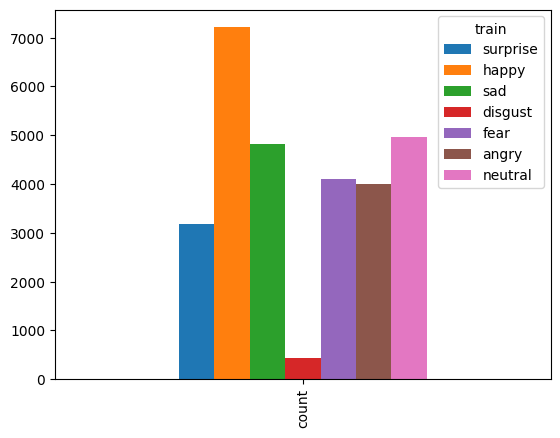

In [ ]:
train_counts.transpose().plot(kind='bar')

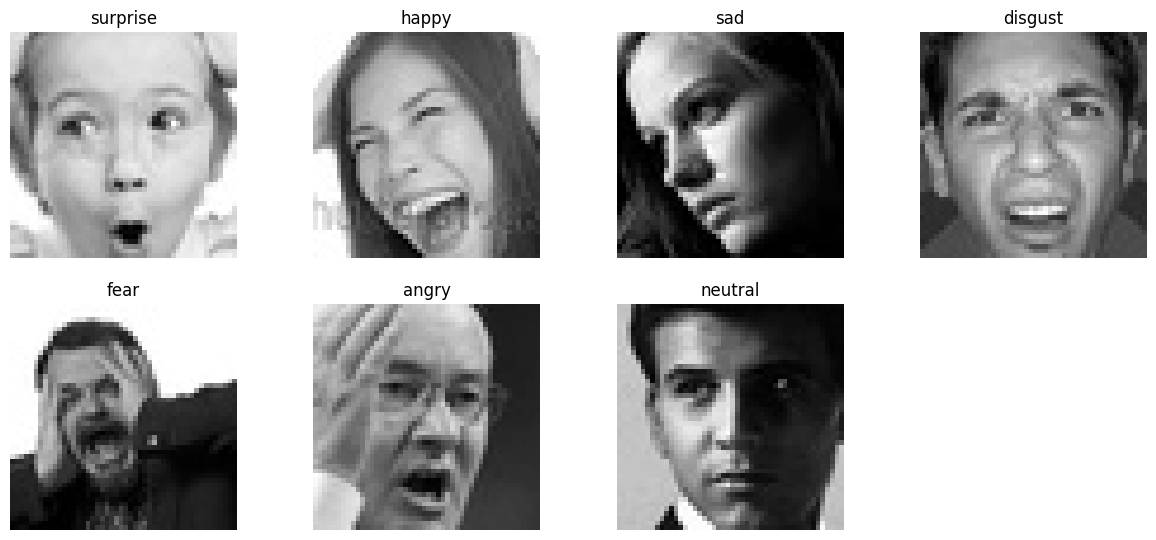

In [ ]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions,1):
  folder = os.path.join(train_dir,emotion)
  img_path = os.path.join(folder,os.listdir(folder)[42])
  img = plt.imread(img_path)
  plt.subplot(3,4,i)
  plt.imshow(img,cmap='gray')
  plt.title(emotion)
  plt.axis('off')

In [ ]:
#plot random images

def plot_images_from_directory(directory_path,class_name,num_images=9):
  image_filenames = os.listdir(directory_path)

  if len(image_filenames) < num_images:
    print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
    num_images = len(image_filenames)

  selected_images = random.sample(image_filenames,num_images)

  fig,axes = plt.subplots(3,3,figsize=(5,5))  #adjust size as needed
  axes = axes.ravel()

  for i ,image_file in enumerate(selected_images):
    image_path = os.path.join(directory_path,image_file)
    image = load_img(image_path)
    axes[i].imshow(image)
    axes[i].set_title(f"Image: {class_name}")
    axes[i].axis('off')   #hide the axis

  plt.tight_layout()
  plt.show()

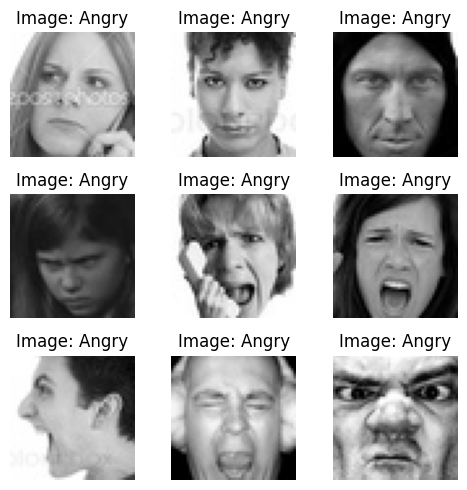

In [ ]:
angry_directory_path = '/content/fer2013/train/angry'
plot_images_from_directory(angry_directory_path,class_name = 'Angry')

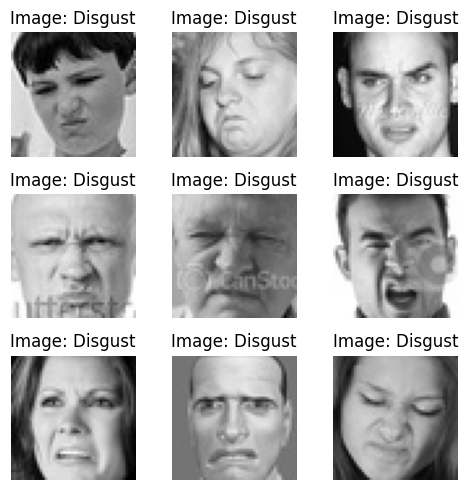

In [ ]:
disgust_directory_path = '/content/fer2013/train/disgust'
plot_images_from_directory(disgust_directory_path,class_name = 'Disgust')

In [ ]:
#  Set some parameters
img_width, img_height = 224, 224  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes

# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(
                                rescale = 1 / 255.,
                                rotation_range=10,
                                zoom_range=0.2,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                # validation_split=0.2
                                )

test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
                                train_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',
                                subset='training',
                                shuffle = True)

test_generator = test_preprocessor.flow_from_directory(
                                test_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',)
                                # subset='validation')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# Get class indices and weights
class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())
y_train = train_generator.classes
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)



{0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [ ]:
classes = 7

# Clear the previous TensorFlow sessionx
tf.keras.backend.clear_session()

# Load the VGG16 base model, excluding its top (fully connected) layers
vgg = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224,224,3),
                                              include_top=False,
                                              weights='imagenet')

94668760/94668760 [==============================] - 0s 0us/step


In [ ]:
ResNet50V2.trainable = True
for layer in ResNet50V2.layers[:-50]:
  layer.trainable=False

In [ ]:
def Create_ResNet50V2_Model():
  model = Sequential([
                    ResNet50V2,
                    Dropout(0.25),
                    BatchNormalization(),
                    Flatten(),
                    # GlobalAveragePooling2D(),
                    # Dense(512, activation='relu'),
                    # Dropout(0.1),
                    Dense(64, activation='relu'),
                    BatchNormalization(),

                    Dropout(0.5),
                    # Dense(128, activation='relu'),
                    # Dropout(0.1),
                    Dense(7, activation='softmax')
                  ])

  return model


model = Create_ResNet50V2_Model()
model.summary()
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 2048)        8192      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

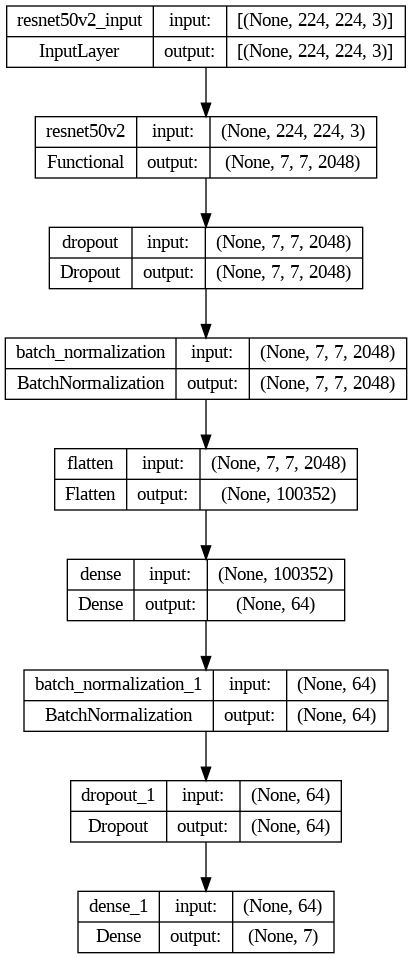

In [ ]:
from keras.utils import plot_model
plot_model(model,  show_shapes=True, show_layer_names=True)

In [ ]:
# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=6,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1



# Model Training


train_history = model.fit(
                          train_generator,
                          steps_per_epoch=200,
                          epochs=50,
                          validation_data=test_generator,
                          validation_steps=100,
                          class_weight=class_weight_dict,
                          callbacks=[reduce_lr , earlystop]
                        )



Epoch 1/50
200/200 [==============================] - 230s 1s/step - loss: 2.1623 - accuracy: 0.3016 - val_loss: 1.9390 - val_accuracy: 0.4756 - lr: 1.0000e-04
Epoch 2/50
200/200 [==============================] - 189s 946ms/step - loss: 1.6459 - accuracy: 0.4048 - val_loss: 1.5187 - val_accuracy: 0.4814 - lr: 1.0000e-04
Epoch 3/50
200/200 [==============================] - 188s 941ms/step - loss: 1.4982 - accuracy: 0.4485 - val_loss: 2.0632 - val_accuracy: 0.4908 - lr: 1.0000e-04
Epoch 4/50
200/200 [==============================] - 188s 941ms/step - loss: 1.4045 - accuracy: 0.4800 - val_loss: 1.2487 - val_accuracy: 0.5477 - lr: 1.0000e-04
Epoch 5/50
200/200 [==============================] - 202s 1s/step - loss: 1.2835 - accuracy: 0.5192 - val_loss: 1.1735 - val_accuracy: 0.5827 - lr: 1.0000e-04
Epoch 6/50
200/200 [==============================] - 199s 995ms/step - loss: 1.2411 - accuracy: 0.5392 - val_loss: 1.1168 - val_accuracy: 0.5944 - lr: 1.0000e-04
Epoch 7/50
200/200 [========

In [ ]:
model.save('fer_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:

train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 22s 195ms/step - loss: 1.0204 - accuracy: 0.6471
final train accuracy = 71.73 , validation accuracy = 64.71


113/113 [==============================] - 25s 211ms/step


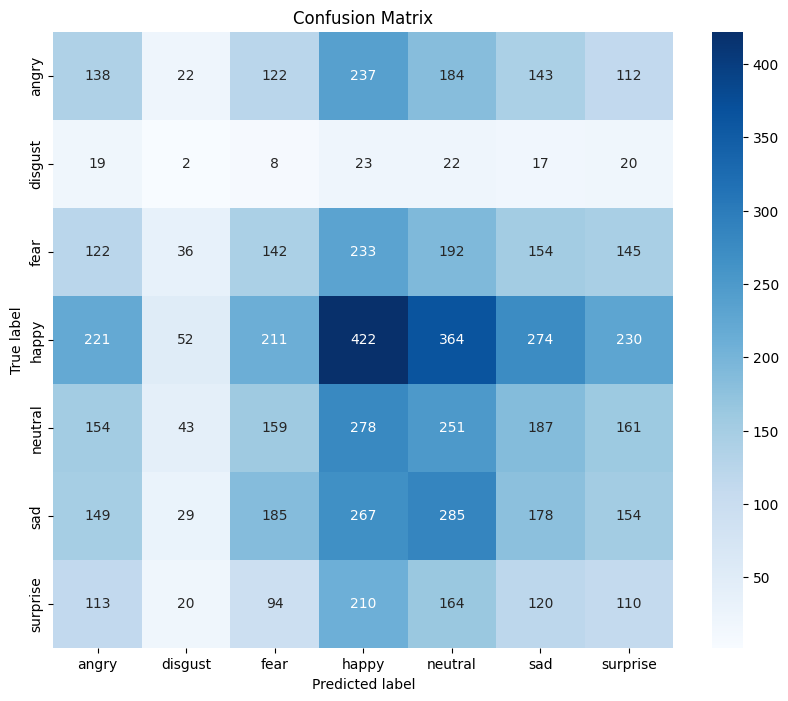

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
#auc roc plot for each class
true_labels = test_generator.classes
preds = model.predict(test_generator, steps=len(test_generator))
pred_labels = np.argmax(preds, axis=1)
classes=list(test_generator.class_indices.keys())

113/113 [==============================] - 22s 196ms/step


In [ ]:
test_loss, test_accu = model.evaluate(test_generator)
print(test_loss,test_accu)

113/113 [==============================] - 21s 183ms/step - loss: 1.0204 - accuracy: 0.6471
1.0204379558563232 0.6471161842346191


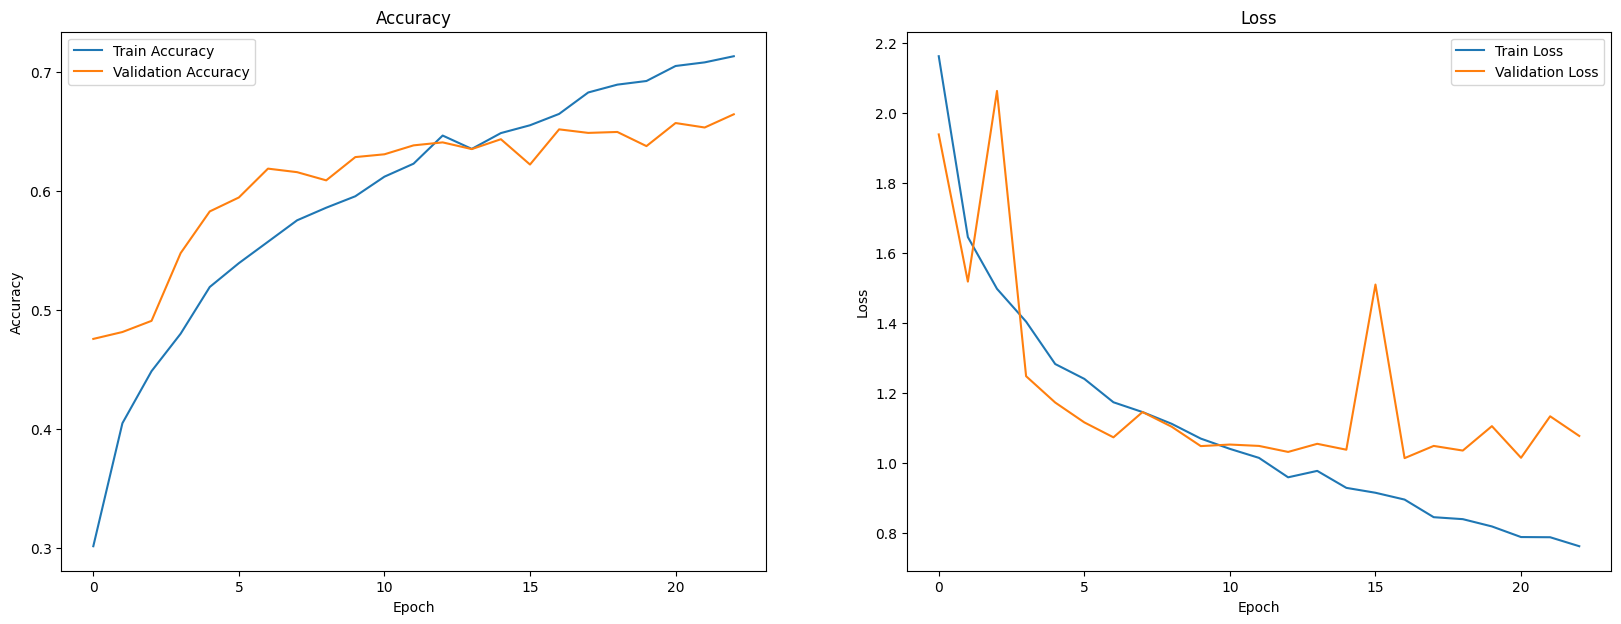

In [ ]:
# prompt: plot model history

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# Plot the training and validation accuracy on the first subplot
ax1.plot(train_history.history['accuracy'], label='Train Accuracy')
ax1.plot(train_history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()


ax2.plot(train_history.history['loss'], label='Train Loss')
ax2.plot(train_history.history['val_loss'], label='Validation Loss')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()


plt.show()
